In [89]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
from osgeo import gdal

import os
import glob
import random

import xgboost as xgb
import shap

#Set figure path 
#base_path = '/Users/conorosullivan/Google Drive/My Drive/UCD/research/Indices/Figures/{}.png'
base_path = '/Users/conorosullivan/Google Drive/My Drive/UCD/research/Indices/'


# Import helper functions from utils.py
import utils 

# Global variables
channels = ['Coastal Aerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water Vapour','SWIR 1','SWIR 2']

indices = ['NDWI', 'MNDWI','AWEIsh', 'WI2015','NDVI', 'BNDVI', 'GNDVI']

standards = ["A",'B','G','R','RE1','RE2','RE3','N','RE4','WV','S1','S2']

In [80]:

name

'Normalized Difference Water Index'

In [102]:
import spyndex
names = []
formulas = []
# Display formula for each indices
for i in indices:
    formula = spyndex.indices[i].formula
    name = str(spyndex.indices[i])
    name = name.split('\n')[0].split(': ')[1]
    names.append(name)
    formulas.append(formula)
    print(name, i,formula)

# Create bands + indices formula table 
channels_ = channels + names
acronym = standards + indices
resolution = [60,10,10,10,20,20,20,10,20,60,20,20] + [""]*len(indices)
formulas = [""]*len(channels) + formulas
formulas = ["${}$".format(i) for i in formulas]

print(len(channels_),len(acronym))

df_formula = pd.DataFrame({'Bands or Indices':channels_,'Acronym':acronym, 'Resolution (m)':resolution, 'Formula':formulas})

df_formula.to_clipboard(index=False)
df_formula


Normalized Difference Water Index NDWI (G-N)/(G+N)
Modified Normalized Difference Water Index MNDWI (G-S1)/(G+S1)
Automated Water Extraction Index with Shadows Elimination AWEIsh B+2.5*G-1.5*(N+S1)-0.25*S2
Water Index 2015 WI2015 1.7204+171*G+3*R-70*N-45*S1-71*S2
Normalized Difference Vegetation Index NDVI (N-R)/(N+R)
Blue Normalized Difference Vegetation Index BNDVI (N-B)/(N+B)
Green Normalized Difference Vegetation Index GNDVI (N-G)/(N+G)
19 19


,Bands or Indices,Acronym,Resolution (m),Formula
0,Coastal Aerosol,A,60,$$
1,Blue,B,10,$$
2,Green,G,10,$$
3,Red,R,10,$$
4,Red Edge 1,RE1,20,$$
5,Red Edge 2,RE2,20,$$
6,Red Edge 3,RE3,20,$$
7,NIR,N,10,$$
8,Red Edge 4,RE4,20,$$
9,Water Vapour,WV,60,$$


# Load data

In [3]:
# Reload utils
import importlib
importlib.reload(utils)

# Initialize data processor
processor = utils.data_processor(channels,standards,indices)

In [4]:
# Load test data
paths = glob.glob("../../data/SWED/test/images/*")

# Update paths: remove images with labelling issues 
path1 = paths.pop(18)
path2 = paths.pop(41-1)
path3 = paths.pop(66-2)
print(path1)
print(path2)
print(path3)

print(paths[0])
print(len(paths))

input, rgb, labels = processor.get_data(paths)

../../data/SWED/test/images/S2A_MSIL2A_20190803T025551_N0213_R032_T54XWG_20190803T043943_image_0_0.tif
../../data/SWED/test/images/S2A_MSIL2A_20190901T101031_N0213_R022_T34VDM_20190901T130348_image_0_0.tif
../../data/SWED/test/images/S2A_MSIL2A_20200405T100021_N0214_R122_T34VDM_20200405T115512_image_0_0.tif
../../data/SWED/test/images/S2A_MSIL2A_20191105T023901_N0213_R089_T50RPN_20191105T062756_image_0_0.tif
95


# Calculate similarity metrics

In [5]:
rows = []
for i in range(len(input)):

    ID = "IMG#{}".format(i)
    
    for j in range(input[0].shape[0]):

        img = np.nan_to_num(input[i][j],0)
        label = labels[i]

        corr_ = processor.img_corr(img,label)
        mutual_info_ = processor.img_mutual_info(img,label)
        avg_intesity_ = processor.avg_intesity(img,label)

        row = [ID,j+1,corr_,mutual_info_,avg_intesity_]
        rows.append(row)
    
df_metrics = pd.DataFrame(rows,columns = ['ID',"band","corr","mutual_info","avg_intesity"])
df_metrics.to_csv(base_path+ 'Metrics_27MAR23.csv',index=False)

In [6]:
# Reload utils
import importlib
importlib.reload(utils)

# Initialize data visualizer
df_metrics = pd.read_csv(base_path+ 'Metrics_27MAR23.csv')
viz = utils.data_visualizer(channels,standards,indices,df_metrics)

11


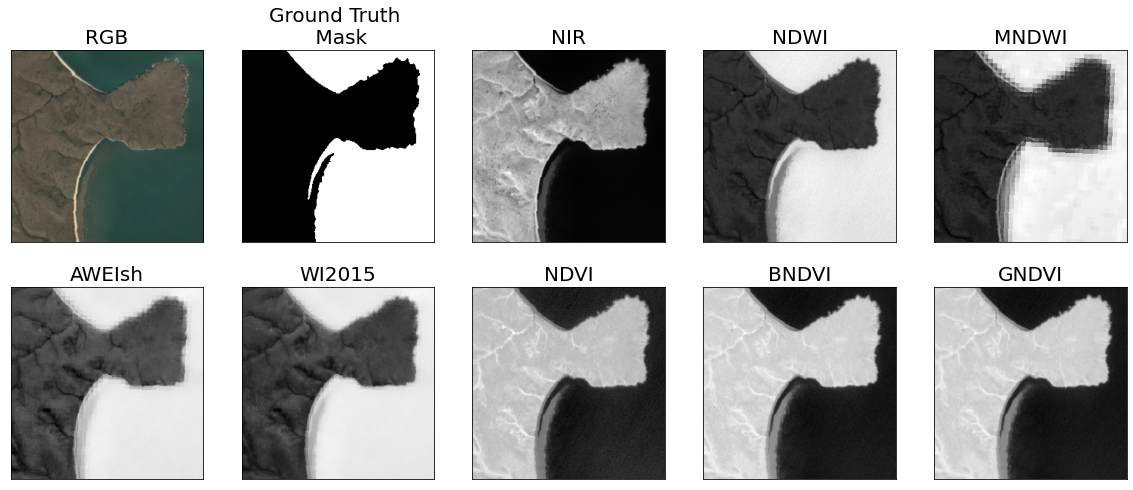

In [7]:
rint = 11
print(rint)
viz.plot_indices(input[rint],rgb[rint],labels[rint],save='Indices_example.png')

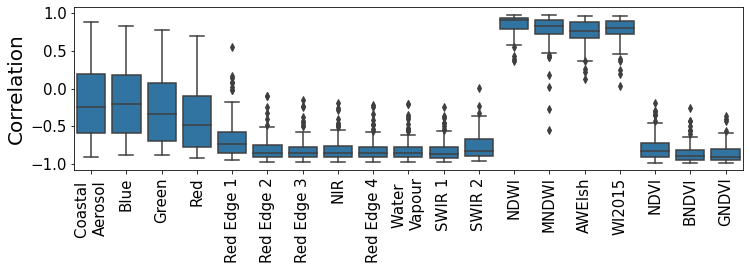

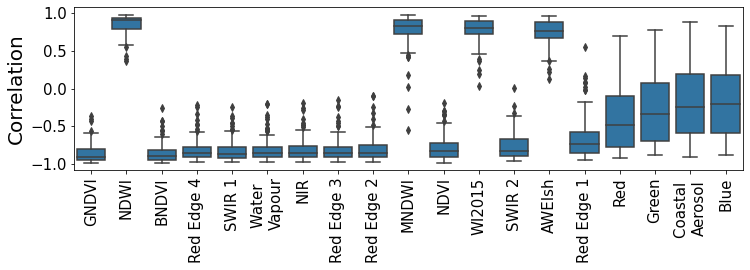

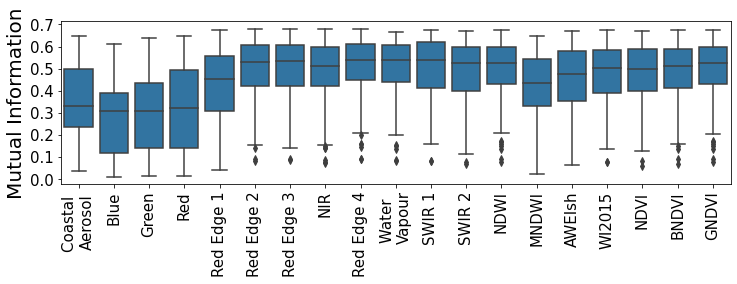

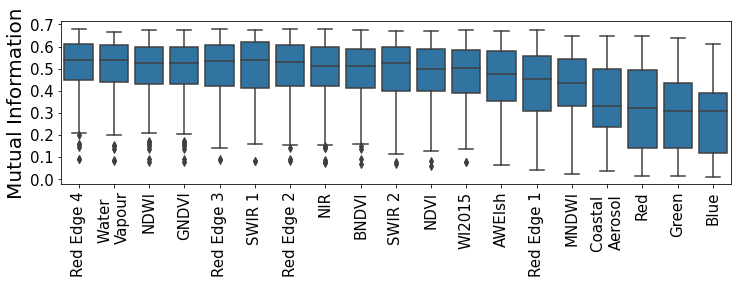

In [8]:
viz.boxplot("corr",ylabel= "Correlation")
viz.boxplot("corr",ylabel= "Correlation",order=True,save='Correlation.png')


viz.boxplot("mutual_info", ylabel = "Mutual Information")
viz.boxplot("mutual_info", ylabel = "Mutual Information",order=True,save='Mutual_Information.png')

# Model based approach

### Train models 

In [9]:
#Create xgboost dataset
xgb_dataset = processor.get_xgb_dataset(input,labels)
xgb_dataset.head()

,Coastal Aerosol,Blue,Green,Red,Red Edge 1,Red Edge 2,Red Edge 3,NIR,Red Edge 4,Water Vapour,SWIR 1,SWIR 2,NDWI,MNDWI,AWEIsh,WI2015,NDVI,BNDVI,lables
0,0.0409,0.0399,0.0644,0.0527,0.1050,0.2166,0.2565,0.2953,0.3025,0.2505,0.1788,0.0946,-0.641924,-0.590981,-0.66250,-31.7474,0.697126,0.761933,0.0
1,0.0409,0.0440,0.0678,0.0569,0.1052,0.1965,0.2370,0.2446,0.2618,0.2505,0.1800,0.0984,-0.565941,-0.573987,-0.57415,-27.6896,0.622554,0.695080,0.0
2,0.0409,0.0425,0.0613,0.0583,0.1052,0.1965,0.2370,0.2132,0.2618,0.2505,0.1800,0.0984,-0.553370,-0.606799,-0.54480,-26.5989,0.570534,0.667579,0.0
3,0.0409,0.0421,0.0627,0.0543,0.0874,0.1820,0.2058,0.2284,0.2398,0.2505,0.1508,0.0805,-0.569220,-0.599617,-0.55720,-25.3623,0.615847,0.688725,0.0
4,0.0409,0.0362,0.0543,0.0436,0.0874,0.1820,0.2058,0.2119,0.2398,0.2505,0.1508,0.0805,-0.592036,-0.643701,-0.55935,-25.6758,0.658708,0.708182,0.0


In [104]:
#Train model on all channels and indices
model_all = xgb.XGBClassifier(objective="binary:logistic",max_depth=2,n_estimators=100, importance_type='gain')

X = xgb_dataset.drop(columns=['lables'])
y = xgb_dataset['lables']

model_all.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [105]:
# Initial model evaluation class
importlib.reload(utils)
eval_all = utils.model_eval(model_all,xgb_dataset)

print(model_all.score(X,y))

eval_all.calc_acc()

0.9748276559930099
Model Accuracy:  0.9748276559930099


0.9748276559930099

In [12]:
X = xgb_dataset.drop(columns=['lables'])
y = xgb_dataset['lables']

from sklearn.inspection import permutation_importance
importance = permutation_importance(model_all, X,y, n_jobs=-1)

In [17]:
#Train model on only channels
model_channels = xgb.XGBClassifier(objective="binary:logistic",max_depth=2,n_estimators=100, importance_type='gain')

X = xgb_dataset[channels]
y = xgb_dataset['lables']

model_channels.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [20]:
# Initial model evaluation class
importlib.reload(utils)
eval_channels = utils.model_eval(model_channels,xgb_dataset)

eval_channels.calc_acc()

Model Accuracy:  0.9734519556949013


0.9734519556949013

### Feature importance

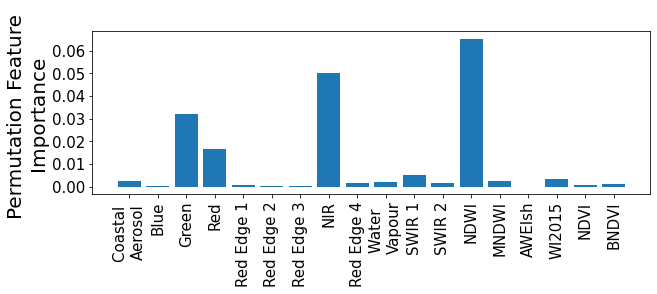

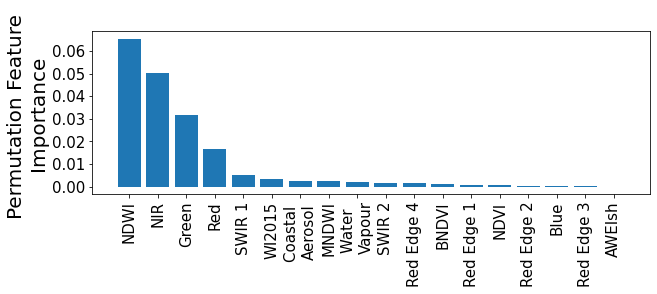

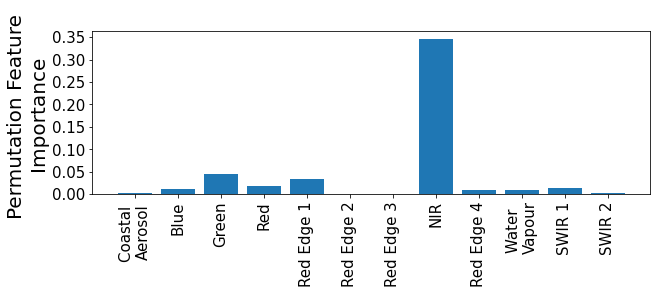

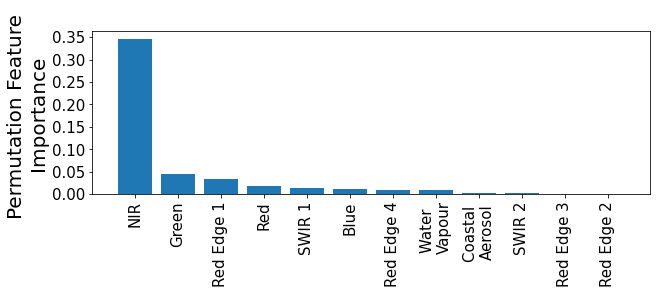

In [15]:
eval_all.plot_feature_importance()
eval_all.plot_feature_importance(order=True,save='Feature_Importance_All.png')

eval_channels.plot_feature_importance()
eval_channels.plot_feature_importance(order=True,save='Feature_Importance_Channels.png')

### Final table of results

In [21]:
# Get Feature Importance
FI_all = eval_all.plot_feature_importance(to_return=True)
FI_channels = eval_channels.plot_feature_importance(to_return=True)

In [54]:
# Update feature importance
FI_all_update = list(FI_all[0:16])
FI_all_update.append(0)
FI_all_update.extend(FI_all[16:]) 

FI_channels_update = list(FI_channels[0:16])
FI_channels_update.extend([0]*len(indices))

In [58]:
df_final = df_metrics[['corr','band','mutual_info']].abs().groupby('band').mean().reset_index()

df_final['band'] = channels + indices
df_final['FI_all'] = FI_all_update
df_final['FI_channels'] = FI_channels_update

df_final = df_final.round(2)
df_final.columns = ['Channel','Correlation','Mutual Information','Feature Importance (All)','Feature Importance (Channels)']
df_final.to_clipboard(index=False)
df_final

,Channel,Correlation,Mutual Information,Feature Importance (All),Feature Importance (Channels)
0,Coastal Aerosol,0.45,0.36,0.00,0.00
1,Blue,0.42,0.28,0.00,0.01
2,Green,0.46,0.30,0.03,0.05
3,Red,0.51,0.32,0.02,0.02
4,Red Edge 1,0.67,0.42,0.00,0.03
5,Red Edge 2,0.80,0.49,0.00,0.00
6,Red Edge 3,0.80,0.49,0.00,0.00
7,NIR,0.80,0.48,0.05,0.35
8,Red Edge 4,0.81,0.50,0.00,0.01
9,Water Vapour,0.81,0.50,0.00,0.01


# Archvie 

### SHAP values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


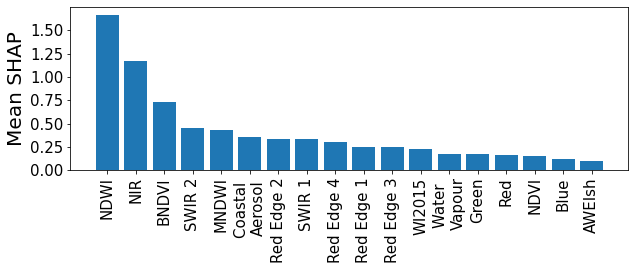

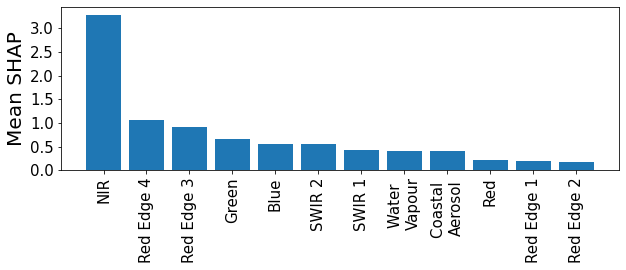

In [77]:
eval_all.plot_shap_importance(order=True,save='SHAP_Importance_All.png')
eval_channels.plot_shap_importance(order=True,save='SHAP_Importance_Channels.png')

### Tides 


In [82]:
# Tide data
tides = pd.read_csv("../../data/SWED/test-set-tidal-state.csv")

# Get tide data for each image
image_ID = []
for name in tides['image']: 
    s = name.split("_")
    ID = "{}_{}".format(s[5],s[9])
    image_ID.append(ID)

tides['ID'] = image_ID
tides = tides.sort_values(["ID","tide"])


# Get low tide data
low_tide = tides[tides['tide']=='low']
low_path = ["../../data/SWED/test/images/" + name for name in low_tide['image']]
low_input, low_rgb, low_labels = processor.get_data(low_path)
low_dataset = processor.get_xgb_dataset(low_input,low_labels)
low_X = low_dataset[channels]

# Get high tide data
high_tide = tides[tides['tide']=='high']
high_path = ["../../data/SWED/test/images/" + name for name in high_tide['image']]
high_input, high_rgb, high_labels = processor.get_data(high_path)
high_dataset = processor.get_xgb_dataset(high_input,high_labels)
high_X = high_dataset[channels]

print(len(low_dataset),len(high_dataset))

3211264 3211264


In [83]:
# Get SHAP values for low tide data
low_shap_values = eval_channels.get_shap_values(low_X)
low_mean = np.abs(low_shap_values.values).mean(0)

# Get SHAP values for high tide data
high_shap_values = eval_channels.get_shap_values(high_X)
high_mean = np.abs(high_shap_values.values).mean(0)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


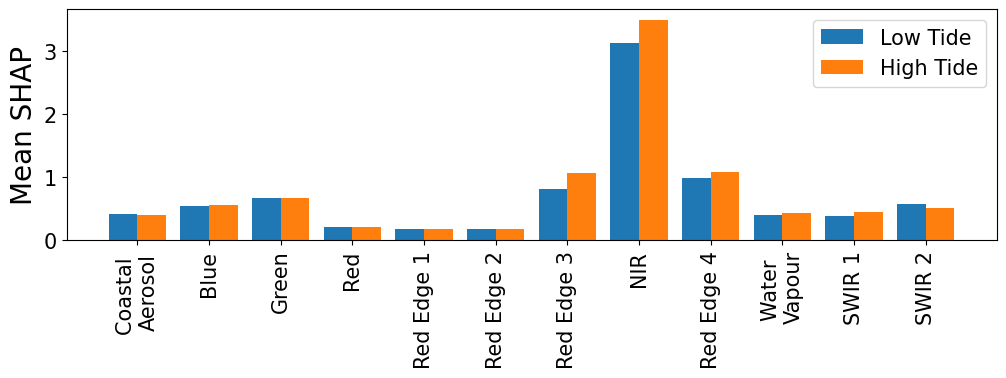

In [160]:
sns.reset_defaults()

# Plot SHAP values
fig, ax = plt.subplots(figsize=(12,3))
fig.set_facecolor('white')

w = 0.4
ax.bar(np.arange(len(channels))-w/2,low_mean,width=w,label='Low Tide')
ax.bar(np.arange(len(channels))+w/2,high_mean,width=w,label='High Tide')

channels_ = [i.replace(" "," \n") if len(i) >=12 else i for i in channels]
ax.set_xticks(np.arange(len(channels_)))
ax.set_xticklabels(channels_,rotation=90,size=15)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel("Mean SHAP",size=20)
ax.legend(fontsize=15)

plt.savefig(base_path + "Figures/tide_shap.png", dpi=300, bbox_inches='tight')

### Pixel type

In [ ]:
sns.reset_defaults()
# Get SHAP values for land pixels
land_x = xgb_dataset[xgb_dataset['lables']==0][channels]
land_shap_values = eval_channels.get_shap_values(land_x)
land_mean = np.abs(land_shap_values.values).mean(0)

# Get SHAP values for water pixels
water_x = xgb_dataset[xgb_dataset['lables']==1][channels]
water_shap_values = eval_channels.get_shap_values(water_x)
water_mean = np.abs(water_shap_values.values).mean(0)

print(len(land_x),len(water_x))

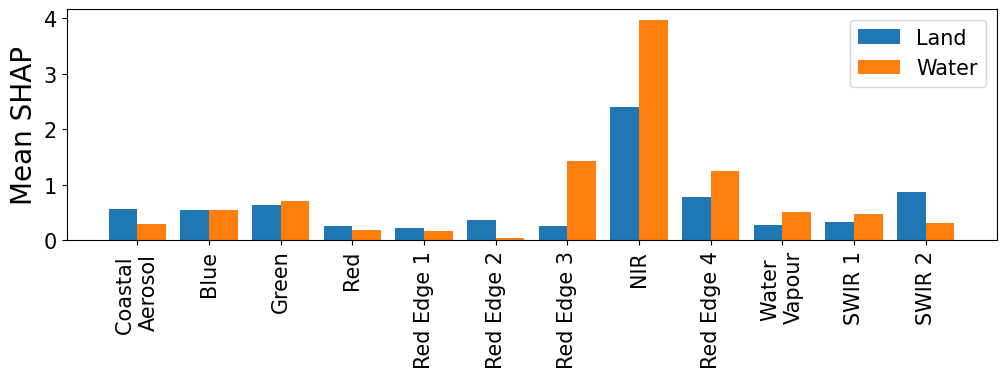

In [161]:
# Plot SHAP values
fig, ax = plt.subplots(figsize=(12,3))
fig.set_facecolor('white')

w = 0.4
ax.bar(np.arange(len(channels))-w/2,land_mean,width=w,label='Land')
ax.bar(np.arange(len(channels))+w/2,water_mean,width=w,label='Water')

channels_ = [i.replace(" "," \n") if len(i) >=12 else i for i in channels]
ax.set_xticks(np.arange(len(channels_)))
ax.set_xticklabels(channels_,rotation=90,size=15)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel("Mean SHAP",size=20)
ax.legend(fontsize=15)

plt.savefig(base_path + "Figures/land_water_shap.png", dpi=300, bbox_inches='tight')

In [159]:
# Differnece in predcit probability and log odds
land_probs = np.array([p[0] for p in model_channels.predict_proba(land_x)])
land_logit = np.log(land_probs/(1-land_probs))
print(np.mean(land_probs),np.mean(land_logit))

water_probs = np.array([p[1] for p in model_channels.predict_proba(water_x)])
water_logit = np.log(water_probs/(1-water_probs))
print(np.mean(water_probs),np.mean(water_logit))


0.93027353 4.113488
0.9479609 5.6381855


# SHAP interaction values 

In [135]:
#Get shap values
X = xgb_dataset[channels]
shap_values = eval_channels.get_shap_values(X)
mean_shap = np.abs(shap_values.values).mean(0)

#Sort channels by mean shap value
index = np.argsort(mean_shap)[::-1]

#Get shap interaction values
y = xgb_dataset['lables']
explainer = shap.Explainer(model_channels)
#n = int(len(X)/10)
shap_interaction = explainer.shap_interaction_values(X)

# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
mean_shap = np.array([m[index] for m in mean_shap])[index]

df = pd.DataFrame(mean_shap,index=labels ,columns=labels )

# Times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)
df = df.round(1)

# Define mask used to cover squares above diagonal 
mask = np.array([[True if i > j else False for i in range(len(df))] for j in range(len(df))])

# Display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.1g',cbar=False,mask=mask)
plt.yticks(rotation=0) 

plt.savefig(base_path+'Figures/abs_mean_shap.png',dpi=200,bbox_inches='tight')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


KeyboardInterrupt: 